# Example 3. CNN + DDA

*[Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Oleg Ovcharenko](https://ovcharenkoo.com/), 2021. "Direct domain adaptation through mutual linear transformations"*

-------
This code is modified from [https://github.com/fungtion/DANN_py3](https://github.com/fungtion/DANN_py3). 

In [22]:
import os
import sys
import random
import numpy as np
from numpy.fft import rfft2, irfft2, fftshift, ifftshift

import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn as nn
import torch.utils.data
from torchvision import datasets
from torchvision import transforms

from components.data_loader import GetLoader
from components.model import CNNModel
from components.test import test
import components.shared as sd

In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

### Init paths

In [3]:
# Paths to datasets
source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)

# Where to save outputs
model_root = './out_ex3_cnn_da'
os.makedirs(model_root, exist_ok=True)

### Init training

In [4]:
cuda = True
cudnn.benchmark = True

# Hyperparameters
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

# manual_seed = random.randint(1, 10000)
manual_seed = 222
random.seed(manual_seed)
torch.manual_seed(manual_seed)
print(f'Random seed: {manual_seed}')

Random seed: 222


### Data

In [5]:
# Transformations / augmentations
img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load MNIST dataset
dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

# Load MNIST-M dataset
train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

# Direct Domain Adaptation (DDA)

## Average auto-correlation
For entire dataset

In [6]:
def get_global_acorr_for_loader(loader):
    """ The average auto-correlation of all images in the dataset """
    global_acorr = np.zeros((3, 28, 15), dtype=np.complex128)
    prog_bar = tqdm.tqdm(loader)
    for data, _ in prog_bar:
        data_f = np.fft.rfft2(data, s=data.shape[-2:], axes=(-2, -1))
        # Auto-correlation is multiplication with the conjucate of self
        # in frequency domain
        global_acorr += data_f * np.conjugate(data_f)
    global_acorr /= len(loader)
    print(global_acorr.shape)
    return np.fft.fftshift(global_acorr)

def route_to(fname):
    """ Shortcut for routing to the save folder """
    return os.path.join(model_root, fname)

# Compute global acorr if not in the folder, load otherwise
if not 'gacorr_dst_tr.npy' in os.listdir(model_root):
    print('Save global acorr')
    gacorr_dst_tr = get_global_acorr_for_loader(dataset_target)
    gacorr_src_tr = get_global_acorr_for_loader(dataset_source)
    np.save(route_to('gacorr_dst_tr.npy'), gacorr_dst_tr)
    np.save(route_to('gacorr_src_tr.npy'), gacorr_src_tr)
else:
    print('Load global acorr')
    gacorr_dst_tr = np.load(route_to('gacorr_dst_tr.npy'))
    gacorr_src_tr = np.load(route_to('gacorr_src_tr.npy'))

Load global acorr


## Average cross-correlation
Pick a random pixel(-s) from each image in the dataset and average

In [7]:
# Window size
crop_size = 1
print(f'Use the crop size for xcorr = {crop_size}')

Use the crop size for xcorr = 1


In [8]:
def crop_ref(x, n=1, edge=5):
    """Crop a window from the image
    Args:
        x(np.ndarray): image [c, h, w]
        n(int): window size
        edge(int): margin to avoid from edges of the image
    """
    if n % 2 == 0: n+=1;
    k = int((n - 1) / 2)
    nz, nx = x.shape[-2:]
    dim1 = np.random.randint(0+k+edge, nz-k-edge)
    dim2 = np.random.randint(0+k, nx-k)
    out = x[..., dim1-k:dim1+k+1, dim2-k:dim2+k+1]
    return out

# crop_ref(np.ones((2, 100, 100)), n=5).shape

In [9]:
def get_global_xcorr_for_loader(loader, crop_size=1):
    # Init the placeholder for average
    rand_pixel = np.zeros((3, crop_size, crop_size))
    
    # Loop over all images in the dataset
    prog_bar = tqdm.tqdm(loader)
    for data, _ in prog_bar:
        rand_pixel += np.mean(crop_ref(data, crop_size).numpy(), axis=0)
    rand_pixel /= len(loader)
    
    # Place the mean pixel into center of an empty image
    c, h ,w = data.shape
    mid_h, mid_w = int(h // 2), int(w // 2)
    embed = np.zeros_like(data)
    embed[..., mid_h:mid_h+1, mid_w:mid_w+1] = rand_pixel
    global_xcorr = np.fft.rfft2(embed, s=data.shape[-2:], axes=(-2, -1))
    return np.fft.fftshift(global_xcorr)


# Compute global xcorr if not in the folder, load otherwise
if not 'gxcorr_dst_tr.npy' in os.listdir(model_root):
# if True:
    print('Save global xcorr')
    gxcorr_dst_tr = get_global_xcorr_for_loader(dataset_target, crop_size)
    gxcorr_src_tr = get_global_xcorr_for_loader(dataset_source, crop_size)
    np.save(route_to('gxcorr_dst_tr.npy'), gxcorr_dst_tr)
    np.save(route_to('gxcorr_src_tr.npy'), gxcorr_src_tr)
else:
    print('Load global xcorr')
    gxcorr_dst_tr = np.load(route_to('gxcorr_dst_tr.npy'))
    gxcorr_src_tr = np.load(route_to('gxcorr_src_tr.npy'))

Load global xcorr


## Train Loader

In [10]:
def flip_channels(x):
    """Reverse polarity of random channels"""
    flip_matrix = np.random.choice([-1, 1], 3)[..., np.newaxis, np.newaxis] 
    return (x * flip_matrix).astype(np.float32)

def shuffle_channels(x):
    """Change order of channels"""
    return np.random.permutation(x)

def normalize_channels(x):
    """Map data to [-1,1] range. The scaling after conv(xcorr, acorr) is not 
    suitable for image processing so this function fixes it"""
    cmin = np.min(x, axis=(-2,-1))[..., np.newaxis, np.newaxis]
    x -= cmin
    cmax = np.max(np.abs(x), axis=(-2,-1))[..., np.newaxis, np.newaxis]
    x /= cmax
    x *= 2
    x -= 1
    return x.astype(np.float32)

In [12]:
class DDALoaderTrain(torch.utils.data.Dataset):
    def __init__(self, loader1, avg_acorr2, p=0.5, crop_size=1):
        super().__init__()
        self.loader1 = loader1
        self.avg_acorr2 = avg_acorr2
        self.p = p
        self.crop_size = crop_size
        
    def __len__(self):
        return len(self.loader1)
        
    def __getitem__(self, item):
        # Get main data (data, label)
        data, label = self.loader1.__getitem__(item)
        data_fft = fftshift(rfft2(data, s=data.shape[-2:], axes=(-2, -1)))
        
        # Get random pixel from another data from the same dataset
        random_index = np.random.randint(0, len(self.loader1))
        another_data, _ = self.loader1.__getitem__(random_index)
        rand_pixel = crop_ref(another_data, self.crop_size)
        
        # Convert to Fourier domain
        c, h ,w = another_data.shape
        mid_h, mid_w = int(h // 2), int(w // 2)
        embed = np.zeros_like(another_data)
        embed[:, mid_h:mid_h+1, mid_w:mid_w+1] = rand_pixel
        pixel_fft = np.fft.rfft2(embed, s=another_data.shape[-2:], axes=(-2, -1))
        pixel_fft = np.fft.fftshift(pixel_fft)
            
        # Cross-correlate the data sample with the random pixel from the same dataset
        xcorr = data_fft * np.conjugate(pixel_fft)

        # Convolve the ruslt with the auto-correlation of another dataset
        conv = xcorr * self.avg_acorr2

        # Reverse Fourier domain and map channels to [-1, 1] range
        data_da = fftshift(irfft2(ifftshift(conv), axes=(-2, -1)))
        data_da = normalize_channels(data_da)
        
        # Apply data augmentations
        if np.random.rand() < self.p:
            data_da = flip_channels(data_da)
        if np.random.rand() < self.p:
            data_da = shuffle_channels(data_da)
            
        # Return a pair of data / label
        return data_da.astype(np.float32), label

In [17]:
dataset_source = DDALoaderTrain(dataset_source, gacorr_dst_tr)
dataset_target = DDALoaderTrain(dataset_target, gacorr_src_tr)

dummy_data, dummy_label = dataset_source.__getitem__(0)
print('Image shape: {}\t Label: {}'.format(dummy_data.shape, dummy_label))

Image shape: (3, 28, 28)	 Label: 5


# Test Loader

In [18]:
class DDALoaderTest(torch.utils.data.Dataset):
    def __init__(self, loader1, avg_acorr2, avg_xcorr1):
        super().__init__()
        self.loader1 = loader1
        self.avg_acorr2 = avg_acorr2
        self.avg_xcorr1 = avg_xcorr1
        
    def __len__(self):
        return len(self.loader1)
        
    def __getitem__(self, item):
        data, label = self.loader1.__getitem__(item)
        data_fft = fftshift(rfft2(data, s=data.shape[-2:], axes=(-2, -1)))
        
        xcorr = data_fft * np.conjugate(self.avg_xcorr1)
        conv = xcorr * self.avg_acorr2

        data_da = fftshift(irfft2(ifftshift(conv), axes=(-2, -1)))
        data_da = normalize_channels(data_da)
        return data_da.astype(np.float32), label

Re-define the test function so it accounts for the average cross-correlation and auto-correlation from source and target datasets

In [19]:
def test(dataset_name, model_root, crop_size=1):
    image_root = os.path.join('dataset', dataset_name)  
    if dataset_name == 'mnist_m':
        test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')
        dataset = GetLoader(
            data_root=os.path.join(image_root, 'mnist_m_test'),
            data_list=test_list,
            transform=img_transform_target
        )
        
        if not 'gxcorr_dst_te.npy' in os.listdir(model_root):
            print('Save global acorr and xcorr')
            # acorr
            gacorr_src_te = get_global_acorr_for_loader(dataset)
            np.save(route_to('gacorr_src_te.npy'), gacorr_src_te)
            # xcorr
            gxcorr_dst_te = get_global_xcorr_for_loader(dataset, crop_size)
            np.save(route_to('gxcorr_dst_te.npy'), gxcorr_dst_te)
        else:
            gacorr_src_te = np.load(route_to('gacorr_src_te.npy'))
            gxcorr_dst_te = np.load(route_to('gxcorr_dst_te.npy'))
            
        # Init loader for MNIST-M
        dataset = DDALoaderTest(dataset, gacorr_src_te, gxcorr_dst_te)
    else:
        dataset = datasets.MNIST(
            root='dataset',
            train=False,
            transform=img_transform_source,
        )
        if not 'gxcorr_src_te.npy' in os.listdir(model_root):
            print('Save global acorr and xcorr')
            # acorr
            gacorr_dst_te = get_global_acorr_for_loader(dataset)
            np.save(route_to('gacorr_dst_te.npy'), gacorr_dst_te)
            # xcorr
            gxcorr_src_te = get_global_xcorr_for_loader(dataset, crop_size)
            np.save(route_to('gxcorr_src_te.npy'), gxcorr_src_te)
        else:
            gacorr_dst_te = np.load(route_to('gacorr_dst_te.npy'))
            gxcorr_src_te = np.load(route_to('gxcorr_src_te.npy'))
            
        # Init loader for MNIST
        dataset = DDALoaderTest(dataset, gacorr_dst_te, gxcorr_src_te)

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8
    )

    """ test """
    my_net = torch.load(os.path.join(model_root, 'mnist_mnistm_model_epoch_current.pth'))
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0

    while i < len_dataloader:
        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        _batch_size = len(t_label)

        if cuda:
            t_img = t_img.cuda()
            t_label = t_label.cuda()

        class_output, _ = my_net(input_data=t_img, alpha=0)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(t_label.data.view_as(pred)).cpu().sum()
        n_total += _batch_size
        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total
    return accu

# Training

In [20]:
dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

In [23]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(50 * 4 * 4, 100))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout())
        self.class_classifier.add_module('c_fc2', nn.Linear(100, 100))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(100))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_fc3', nn.Linear(100, 10))
        self.class_classifier.add_module('c_softmax', nn.LogSoftmax(dim=1))

    def forward(self, input_data, alpha):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)

        class_output = self.class_classifier(feature)

        return class_output, 0

In [24]:
# load model
my_net = CNNModel()

# setup optimizer
optimizer = optim.Adam(my_net.parameters(), lr=lr)

loss_class = torch.nn.NLLLoss()

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()

for p in my_net.parameters():
    p.requires_grad = True

In [25]:
# Record losses for each epoch (used in compare.ipynb)
losses = {'test': {'acc_bw': [], 'acc_color': []}}
name_losses = 'losses.pkl'

Losses from previous run found!
Load dict from ./out_ex3_cnn_da/losses.pkl


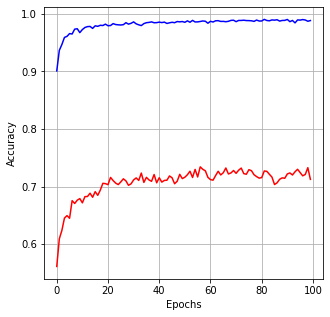

In [26]:
if not name_losses in os.listdir(model_root):
# if True:
    # training
    best_accu_t = 0.0
    for epoch in range(n_epoch):

        len_dataloader = min(len(dataloader_source), len(dataloader_target))
        data_source_iter = iter(dataloader_source)
        data_target_iter = iter(dataloader_target)

        for i in range(len_dataloader):

            p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # training model using source data
            data_source = data_source_iter.next()
            s_img, s_label = data_source

            my_net.zero_grad()
            batch_size = len(s_label)

            if cuda:
                s_img = s_img.cuda()
                s_label = s_label.cuda()

            class_output, _ = my_net(input_data=s_img, alpha=alpha)
            err_s_label = loss_class(class_output, s_label)

            err = err_s_label
            err.backward()
            optimizer.step()

            sys.stdout.write('\r epoch: %d, [iter: %d / all %d], err_s_label: %f' \
                  % (epoch, i + 1, len_dataloader, err_s_label.data.cpu().numpy()))
            sys.stdout.flush()
            torch.save(my_net, '{0}/mnist_mnistm_model_epoch_current.pth'.format(model_root))

        print('\n')
        accu_s = test(source_dataset_name, model_root)
        print('Accuracy of the %s dataset: %f' % ('mnist', accu_s))
        accu_t = test(target_dataset_name, model_root)
        print('Accuracy of the %s dataset: %f\n' % ('mnist_m', accu_t))

        losses['test']['acc_bw'].append(accu_s)
        losses['test']['acc_color'].append(accu_t)

        if accu_t > best_accu_t:
            best_accu_s = accu_s
            best_accu_t = accu_t
            torch.save(my_net, '{0}/mnist_mnistm_model_epoch_best.pth'.format(model_root))

    print('============ Summary ============= \n')
    print('Accuracy of the %s dataset: %f' % ('mnist', best_accu_s))
    print('Accuracy of the %s dataset: %f' % ('mnist_m', best_accu_t))
    print('Corresponding model was save in ' + model_root + '/mnist_mnistm_model_epoch_best.pth')
    sd.save_dict(os.path.join(model_root, 'losses.pkl'), losses)
else:
    path_losses = os.path.join(model_root, name_losses)
    print(f'Losses from previous run found!')
    losses = sd.load_dict(path_losses)
    sd.plot_curves(losses)

In [27]:
print('============ Summary ============= \n')
print('Accuracy of the %s dataset: %f' % ('mnist', max(losses['test']['acc_bw'])))
print('Accuracy of the %s dataset: %f' % ('mnist_m', max(losses['test']['acc_color'])))
print('Corresponding model was saved into ' + model_root + '/mnist_mnistm_model_epoch_best.pth')

============ Summary ============= 

Accuracy of the mnist dataset: 0.990200
Accuracy of the mnist_m dataset: 0.734141
Corresponding model was saved into ./out_ex3_cnn_da/mnist_mnistm_model_epoch_best.pth
